# Deutsch-Jozsa Algorithm

---

**Author:** Javier Fernández  
**Date:** 2026-02-02 

---



## Table of contents
- [Imports and requirements](#imports-and-requirements)
- [Runtime setup](#ibm-quantum-runtime-setup)
- [Algorithm Description](#algorithm-overview)
- [Step 1: Map](#step-1-map)
- [Step 2: Optimize](#step-2-optimize)
- [Step 3: Execute](#step-3-execute)
- [Step 4: Post Processing](#step-4-post-process-and-interpretation)
- [References](#references)



## Imports and requirements


To run this notebook it is requiered a python version >= 3.10, personally, I am using python 3.11

In [33]:
from platform import python_version
print(python_version())

3.11.14


In [ ]:
#%pip install -r requirements.txt

In [ ]:
from dotenv import load_dotenv
import os
import random

import qiskit
from qiskit import QuantumCircuit,QuantumRegister, ClassicalRegister

from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler, QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from collections import Counter

from results_step3 import raw_results_opt0, raw_results_opt3


In [36]:
print(f"Qiskit version: {qiskit.__version__}")

Qiskit version: 2.3.0


You should have Qiskit version `>=2.0.0`. If you see a lower version, you need to restart your kernel and reinstall the library.

## IBM Quantum Runtime setup

This configuration step is optional and only required if the circuit is executed on real quantum hardware.

Firstly we will setup the qiskit_ibm_runtime service so we can execute our circuit on a real hardware.
> **Note:**  
> It is highly recommended to check the [official IBM Quantum documentation](https://quantum.ibm.com/docs/).  
>
> In this notebook, we will use the **`.env` method**.  
> Create a `.env` file in the same folder as this notebook and write your **API key** and **CRN** there.  
>
> This approach keeps your credentials secure and out of the public repository.


In [37]:
# Load automatically the .env file from the root of the project 
load_dotenv(override=True)

# Check if the environment variables are set
print("Token (first 6 chars):", os.environ["IBM_QUANTUM_TOKEN"][:6], "...")

# Setup the IBM Quantum Runtime service
service = QiskitRuntimeService(
    channel=os.environ["IBM_QUANTUM_CHANNEL"], 
    token=os.environ["IBM_QUANTUM_TOKEN"], # Your IBM Quantum API key if you are using IBM Quantum Cloud
    instance=os.environ["IBM_QUANTUM_INSTANCE"] # CRN for IBM Quantum Cloud
)
# Check the available backends, if error then your .env is not correctly set
print("Available backends:")
backends = service.backends()
for backend in service.backends():

    print(" -", backend.name)

qiskit_runtime_service._discover_account:WARNING:2026-01-28 00:32:08,449: Loading account with the given token. A saved account will not be used.


Token (first 6 chars): 6vKBpe ...
Available backends:
 - ibm_fez
 - ibm_marrakesh
 - ibm_torino


# Deutsch-Jozsa-algorithm-implementation
### Algorithm overview

The Deutsch–Jozsa algorithm is one of the first examples showing a clear
separation between classical and quantum computation.
It determines whether a Boolean function is constant or balanced
using a single oracle query in the ideal quantum case.

We will follow the Qiskit workflow pattern: **Map → Optimize → Execute → Post-process**.  
## Step 1: Map

We follow the standard formulation of the Deutsch–Jozsa algorithm as presented in the literature.

We start by initializing the qubit registers.
This corresponds to the initial state $|0\rangle^{\otimes n}$ for Alice's register
and $|1\rangle$ for Bob's qubit.




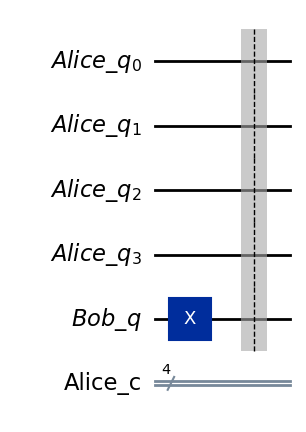

In [38]:
# Define the initial state |ψ0⟩ = |0...01⟩
def psi_0(n:int):
    alice_qr = QuantumRegister(n,name='Alice_q')
    bob_qr = QuantumRegister(1,name= 'Bob_q')
    alice_cr = ClassicalRegister(n,name='Alice_c')
    qc = QuantumCircuit(alice_qr,bob_qr,alice_cr)
    qc.x(n)
    qc.barrier()
    return qc,alice_qr,alice_cr,bob_qr
# For example n = 4, 4 qubits for Alice and 1 for Bob
n = 4
qc,alice_qr,alice_cr,bob_qr = psi_0(n)
qc.draw('mpl')

As you can see. We initialize the circuit in the state $$ |\psi_0\rangle = |0\rangle^{\otimes n} |1\rangle $$ <br> 
To continue we need to create an entangled $|\psi_1\rangle =  H^{\otimes n+1}|\psi_0\rangle $ 
which is $$  H^{\otimes n}|0\rangle  \otimes H|1\rangle$$

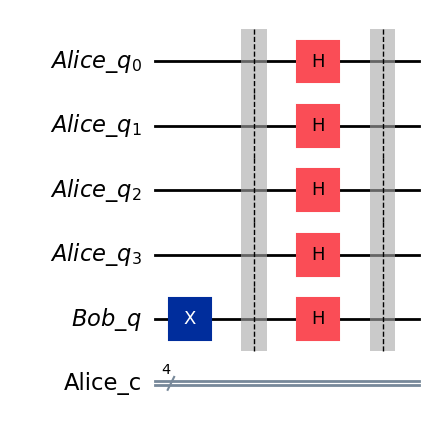

In [39]:
def psi_1(qc:QuantumCircuit,n:int,alice_qr:QuantumRegister,alice_cr:ClassicalRegister,bob_qr:QuantumRegister)->QuantumCircuit:
    qc.h(alice_qr)
    qc.h(bob_qr)
    qc.barrier()
    return qc
qc= psi_1(qc,n,alice_qr,alice_cr,bob_qr)
qc.draw('mpl')

We obtain$$ |\psi_1 \rangle = \displaystyle\sum_{x \in \{0,1\}^n}  \frac{|x\rangle}{\sqrt{2^n}} \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}} $$ <br>
For example for $ n = 2 $ $$  |\psi_1\rangle = \frac {|00\rangle +|01\rangle + |10\rangle + |11\rangle}{2} \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}}  $$ <br>


Now the query register is a superposition of all values. Then it is Bob's turn to evaluate $$ U_f : |Alice,Bob\rangle \rightarrow |Alice,Bob \oplus f(x)\rangle$$ <br>

It is important to understand how $ f(x) $ is chosen. Initially before we execute the quantum circuit an oracle chooses between balanced or constant function. For all shots of the execution this decision will be maintained. Now let's recap how $f(x) $ works:
$$
constant \rightarrow f(x) = 
\begin{cases}
0 \ \forall x
\\
1 \ \forall x 

\end{cases}

$$

$$
balanced \ \longrightarrow\
|\{x : f(x)=0\}| = |\{x : f(x)=1\}| = 2^{n-1}
$$

In [40]:
# Define a seed for better reproduction
seed = 23
random.seed(seed)
# Which function we will use for one execution
def choose_const_bal() -> int:
    return random.choice([0, 1, 2])
     
which_fun = choose_const_bal()
print(which_fun)

1


As we have seen, $f(x)$ can output 2 values rather if it is balanced or constant. Let's check how $ U_f $ works:
$$
|\psi_2\rangle = \frac{1}{\sqrt{2^n}} \big[ U_f|x,0\rangle - U_f|x,1\rangle] = \frac{1}{\sqrt{2^n}} \big[ |x,0\oplus f(x)\rangle - |x,1\oplus f(x)\rangle] = \frac{1}{\sqrt{2^n}} \big[ |x,f(x)\rangle - |x,1\oplus f(x)\rangle]
$$ 
<br>




Now we will explain how $ U_f $ will change depending on the posible values of  $ f(x) $
$$
f(x) = 0 \longrightarrow |\psi_2\rangle = \frac {1}{\sqrt{2^n}} |x,0\rangle - |x,1\rangle \\
f(x) = 1 \longrightarrow |\psi_2\rangle = \frac {1}{\sqrt{2^n}} |x,1\rangle - |x,0\rangle  =\frac {1}{\sqrt{2^n}} \big[ -|x,0\rangle-|x,1\rangle\big]

$$
$$ |\psi_2\rangle = \sum_x \frac{(-1)^{f(x)}|x\rangle}{\sqrt{2^n}} \big[ \frac {|0\rangle-|1\rangle }{\sqrt{2}}\big] $$

This phenomena is called phase kickback. This quantum property is one of the most useful  within quantums algorithms. For more detail see: https://quantum.cloud.ibm.com/learning/en/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/phase-estimation-procedure

Let's express this phenomena in terms of quantum gates.

In [41]:
#Let's define all the posible functions
def constan0(qc:QuantumCircuit)->QuantumCircuit:
    # We apply the identity
    return qc

def constant1(qc:QuantumCircuit,bob_qr:QuantumRegister)->QuantumCircuit:
    qc.x(bob_qr[0])
    return qc

For the balanced function, we should be more cautious. As we can see $ U_f $ is applied to each $ |x\rangle $. So in the case
$$ 
f(x) = x \longrightarrow  |x\rangle |y\oplus x\rangle \longrightarrow CNOT
$$ 
In the second case:
$$
f(x) =  \neg x \longrightarrow  |x\rangle |y\oplus  \neg x\rangle   ~=~ |x\rangle |y\oplus ( 1 \oplus x\rangle ) =  |x\rangle |(y\oplus  1 )\oplus  x\rangle  \longrightarrow  X \ CNOT
$$

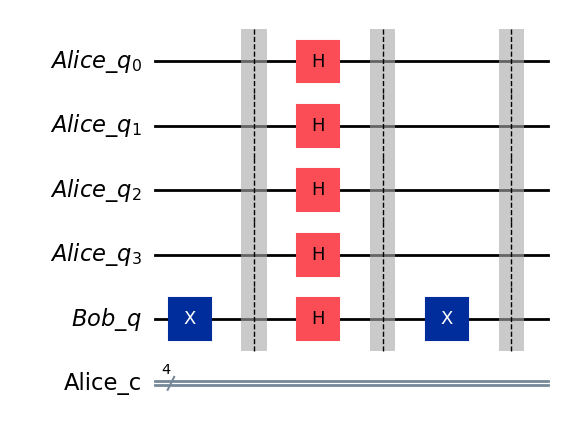

In [42]:
def balanced(qc:QuantumCircuit,n:int,alice_qr:QuantumRegister,bob_qr:QuantumRegister,balancer)->QuantumCircuit:
    if balancer <=0:
        balancer = random.random()
        print('Balancer was less than 0, new value assigned:', balancer)
    elif balancer >=1:
        balancer = random.random()
        print('Balancer was greater than 1, new value assigned:', balancer)
    if balancer <= 0.5: 
        qc.cx(alice_qr,bob_qr) # N CNOT gates 
        return qc
    else:
        qc.x(bob_qr)
        qc.cx(alice_qr,bob_qr) 
        return qc

def uf(qc:QuantumCircuit,n:int,which_fun:int,alice_qr:QuantumRegister,bob_qr:QuantumRegister,balancer)->QuantumCircuit:
    if which_fun == 0:
        qc = constan0(qc)
    elif which_fun == 1:
        qc= constant1(qc,bob_qr)
    else:
        qc = balanced(qc,n,alice_qr,bob_qr,balancer)
    qc.barrier()
    return qc

balancer_exampler = random.random()
qc = uf(qc,n,which_fun,alice_qr,bob_qr,balancer_exampler)
qc.draw('mpl')

To conclude, we just have to apply a Hadamard gate to Alice's qubits, and measure them.

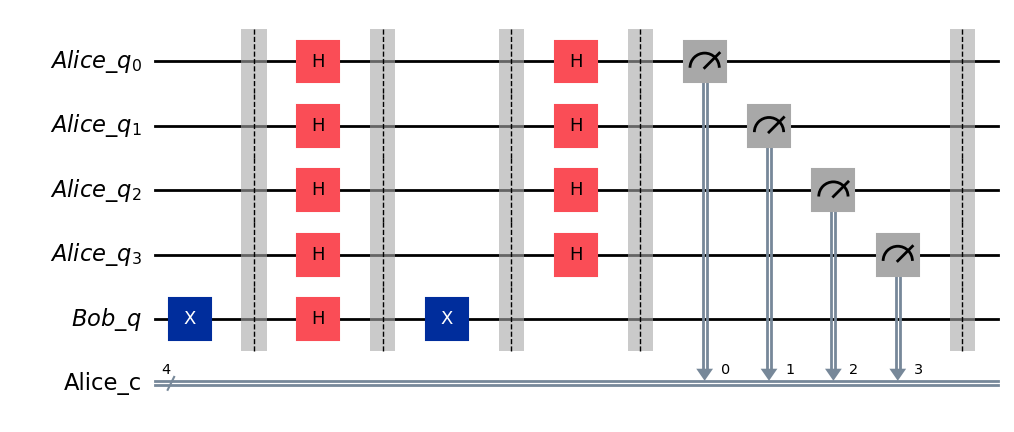

In [43]:
def psi_3(qc:QuantumCircuit,n:int,alice_qr:QuantumRegister,alice_cr:ClassicalRegister,bob_qr:QuantumRegister)-> QuantumCircuit:
    qc.h(alice_qr)
    qc.barrier()
    qc.measure(alice_qr,alice_cr)
    qc.barrier()
    return qc
qc = psi_3(qc,n,alice_qr,alice_cr,bob_qr)
qc.draw('mpl')

Finally we obtain:
$$
|\psi_3\rangle = H ^{\otimes n}|x\rangle |y\rangle \longrightarrow
|\psi_3\rangle = \sum_z \sum_x \frac{(-1)^{xz+f(x)}|z\rangle}{2^n} \big[ \frac{|0\rangle-|1\rangle}{\sqrt{2}}\big]
$$
Where $ zx $ is the bitwise inner produnct modulo 2. <br>
At last, is Alice's turn to measure her query registers. The amplitudes should be
$$
f(x) = constant \rightarrow \pm1 \\
f(x) = balanced \rightarrow 0
$$
And we should measure
$$
f(x) = constant \rightarrow 0  \ \forall \ qubits \\
f(x) = balanced \rightarrow \ne 0 \ for \ at \ least \ 1 \ qubit
$$
Now our Quantum Circuit is finally complete. Let's group all of our functions.

In [44]:
def Deutsch_Jozsa_circuit(n:int,which_fun = choose_const_bal,balancer = None)-> dict:
    if balancer is None:
        balancer = random.random()
    qc,alice_qr,alice_cr,bob_qr = psi_0(n)
    qc= psi_1(qc,n,alice_qr,alice_cr,bob_qr)
    # It's important to clarify that if we do not give any value to 'which_fun' then it will be random
    if which_fun not in [0,1,10]:
        print('Incorrect value for which_fun, a random function will be chosen')
        which_fun = choose_const_bal()
    qc = uf(qc,n,which_fun,alice_qr,bob_qr,balancer)
    qc = psi_3(qc,n,alice_qr,alice_cr,bob_qr)

    # Return the circuit, function type, and balancer value
    if which_fun ==0:
        #print('The function is constant 0')
        return {"qc": qc, 'oracle_type':'constant', 'oracle_variant':0}
    elif which_fun ==1:
        #print('The function is constant 1')
        return {"qc": qc, 'oracle_type':'constant', 'oracle_variant':1}

    else:
        #print('The function is balanced')
        if balancer <=0.5:
            #print('Balancer used:', balancer, ' (CNOTs)')
            return {"qc": qc, 'oracle_type':'balanced', 'oracle_variant':'parity'}
        else:
            #print('Balancer used:', balancer, ' (Inverted CNOTs)')
            return {"qc": qc, 'oracle_type':'balanced', 'oracle_variant':'inverted parity'}

Function used: balanced inverted parity


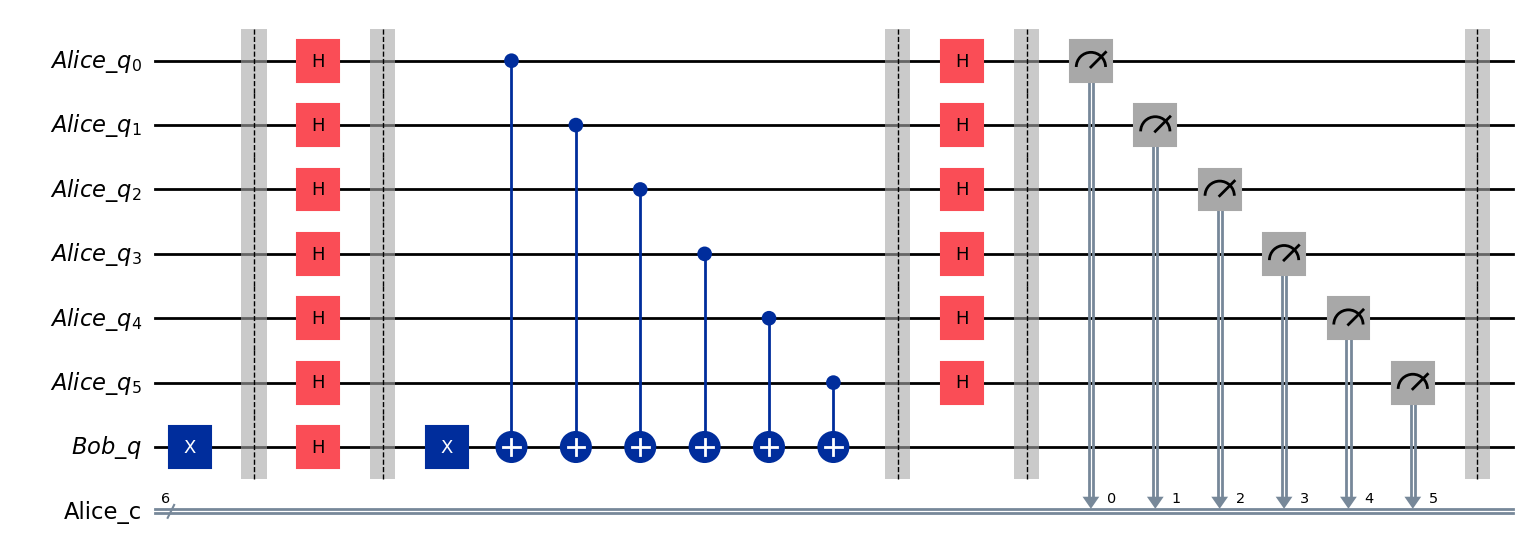

In [45]:
dj_case1= Deutsch_Jozsa_circuit(n = 6, which_fun=10,balancer=0.7)
qc1 = dj_case1["qc"]
print('Function used:',dj_case1['oracle_type'], dj_case1['oracle_variant'])
draw1 = qc1.draw('mpl')
draw1

In this implementation, a specific balanced oracle is considered. The oracle corresponds to a parity-type function such that, in the ideal case, the Deutsch–Jozsa algorithm is expected to return: $ |111111 \rangle $, when measuring the input register.

This choice represents one concrete instance of a balanced oracle within the Deutsch–Jozsa framework and is sufficient to illustrate the behavior of the algorithm.

## Step 2: Optimize 

In the NISQ regime, circuit depth and gate count play a critical role in determining
the reliability of results, motivating the use of different transpilation optimization levels.


In [46]:
# Select least busy real backend
real_backend = service.least_busy(operational=True, simulator=False)

# Pass managers for real backend (opt level 0 and 3)
pm0 = generate_preset_pass_manager(
    backend=real_backend,
    optimization_level=0,
    seed_transpiler=seed
)

pm3 = generate_preset_pass_manager(
    backend=real_backend,
    optimization_level=3,
    seed_transpiler=seed
)

# ISA circuits for real hardware
real_isa_qc_0 = pm0.run(qc1)
real_isa_qc_3 = pm3.run(qc1)

# Ideal backend
ideal_backend = AerSimulator()

# Ideal circuit 
ideal_pm = generate_preset_pass_manager(
    backend=ideal_backend,
    seed_transpiler=seed
)
ideal_isa_qc = ideal_pm.run(qc1)


We analyze the differences between the depth of an ideal (backend-free) circuit and the same circuit transpiled for a real quantum backend using different optimization levels.

In [47]:
# Original circuit depth
print('Original circuit depth:', qc1.depth())
# For the ideal backend
#Optimized circuit depth level 0
print('Optimized circuit depth level 0:', real_isa_qc_0.depth())
#Optimized circuit depth level 3
print('Optimized circuit depth level 3:', real_isa_qc_3.depth())

Original circuit depth: 11
Optimized circuit depth level 0: 99
Optimized circuit depth level 3: 40


As we can see a higher optimization level leads to  a significant reduction in circuit depth. Now lets execute each circuit to compare if differents levels of optimization translates into better measurements outcomes.


## Step 3: Execute

Now that the circuit has been optimized for the selected backend, we proceed to its execution.  
At small problem sizes, quantum circuits can be efficiently simulated on classical computers. Therefore, we first execute the circuit on an ideal simulator to verify that the Deutsch–Jozsa algorithm is correctly implemented.

> **Note**  
> A sanity check was performed on all four oracle implementations to verify correct Deutsch–Jozsa behavior.


In [48]:
shots = 1024
# Execute on the ideal backend
ideal_job = ideal_backend.run(ideal_isa_qc,shots=shots,seed_simulator=seed)
ideal_result = ideal_job.result()
ideal_counts = ideal_result.get_counts()
print("Ideal backend counts:", ideal_counts)
print('Function used:',dj_case1['oracle_type'], dj_case1['oracle_variant'])




Ideal backend counts: {'111111': 1024}
Function used: balanced inverted parity


The ideal execution yields the expected theoretical outcome, confirming the correct
implementation of the Deutsch–Jozsa algorithm.

When executing the same circuit on real quantum hardware, noise and gate errors are
expected to affect the measurement outcomes, even for simple algorithms.


In [49]:
# TURN ON TO RUN ON HARDWARE
RUN_HARDWARE = False


if RUN_HARDWARE:
    sampler = Sampler(mode = real_backend)
    # Execute on the real backend with optimization level 0
    # If you want to run the job uncomment the next lines
    real_job = sampler.run([real_isa_qc_0, real_isa_qc_3], shots=shots,)
    real_result = real_job.result()
    result_opt0 = real_result[0]
    # Since the classical register was renamed to 'Alice_c',
    # the measurement results must be accessed using this register name.
    print('Name of classical register in qc1:', qc1.cregs)
    bitstrings_opt0 = result_opt0.data.Alice_c.get_bitstrings()


else:
    bitstrings_opt0 = raw_results_opt0



The following results correspond to the execution of the circuit on real quantum hardware with optimization level 0.


Most frequent outcome: 111101 (274 shots)


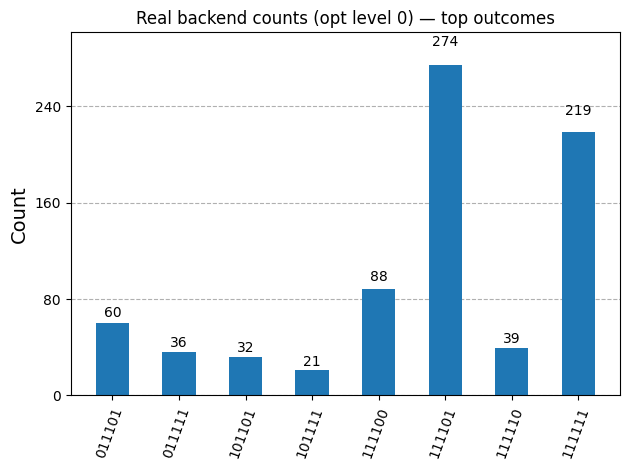

In [50]:
# Get counts
counts_opt0 = Counter(bitstrings_opt0)
# Show the results
dominant_0, freq_0 = counts_opt0.most_common(1)[0]
print(f"Most frequent outcome: {dominant_0} ({freq_0} shots)")
# Plot histogram we only for the top 8 outcomes for readability
k = 8
top_counts_0 = dict(counts_opt0.most_common(k))
plot_histogram(top_counts_0, title="Real backend counts (opt level 0) — top outcomes")

Note that in Qiskit the displayed bitstrings follow little-endian ordering; therefore, a measured string such as `10` corresponds to the state $ |01\rangle $.
\
The following results correspond to the execution of the circuit on real quantum hardware with optimization level 3.




Most frequent outcome: 111111 (681 shots)


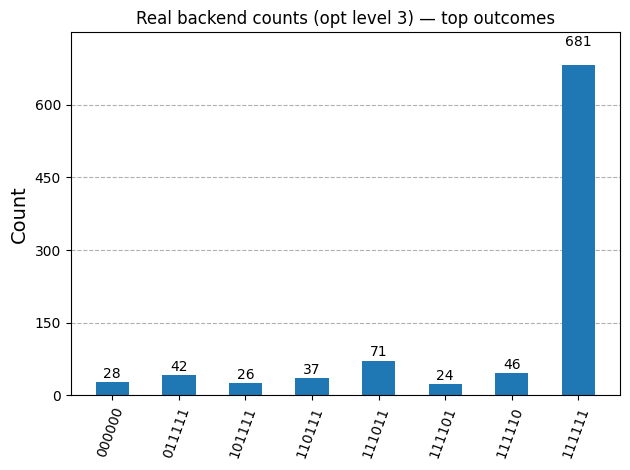

In [51]:
if RUN_HARDWARE:
    result_opt3 = real_result[1]
    bitstrings_opt3 = result_opt3.data.Alice_c.get_bitstrings()

else:
    bitstrings_opt3 = raw_results_opt3

# Get counts
counts_opt3 = Counter(bitstrings_opt3)
# Show the results
dominant_3, freq_3 = counts_opt3.most_common(1)[0]
print(f"Most frequent outcome: {dominant_3} ({freq_3} shots)")
# Plot histogram we only for the top 8 outcomes for readability
k = 8
top_counts_3 = dict(counts_opt3.most_common(k))
plot_histogram(top_counts_3, title="Real backend counts (opt level 3) — top outcomes")

## Step 4: Post-process and interpretation

In the ideal case, the measurement outcomes clearly distinguish between constant
and balanced functions, as predicted by the Deutsch–Jozsa algorithm.

On real quantum hardware, the results show deviations from the ideal behavior,
which are consistent with the presence of noise and gate errors.
Nevertheless, higher transpilation optimization levels reduce circuit depth and
lead to more reliable measurement distributions.

These results highlight both the theoretical advantage of the Deutsch–Jozsa
algorithm and the practical limitations imposed by current NISQ devices.


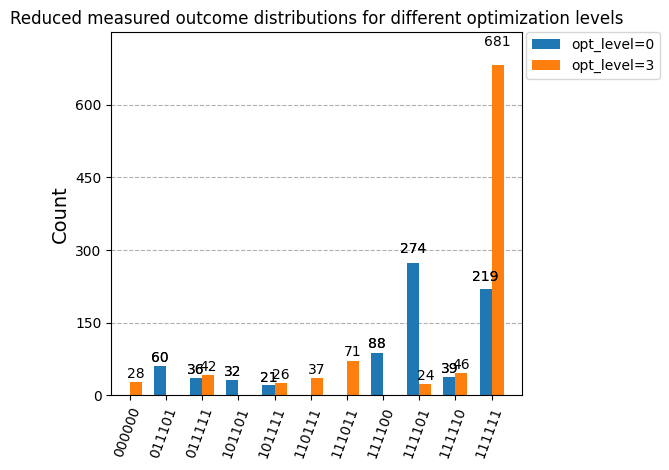

In [52]:
# Compare both optimization levels
plot_histogram(
    [top_counts_0, top_counts_3],
    legend=['opt_level=0', 'opt_level=3'],
    title='Reduced measured outcome distributions for different optimization levels'
)


>Figure: Reduced outcome distributions for real-hardware executions at optimization levels 0 and 3. The target bitstring 111111 dominates only in the optimized circuit (level 3), while level 0 exhibits a more dispersed distribution.

After execution on real quantum hardware, noise and gate errors introduce variations in the measured outcomes, making real executions non-deterministic. To interpret the results, we focus on the measurement outcome with the highest probability (or highest number of counts), which is defined as the dominant outcome. Depending on the optimization level, this dominant outcome may approach the ideal reference result with different degrees of accuracy.

In our specific implementation, when the balanced oracle is applied, the expected outcome on the input register is the bitstring 111111, as indicated by the reference result obtained from the ideal backend.

When executing the circuit with optimization level 0 on real hardware, the dominant outcome does not correspond to the expected ideal result. This behavior can be attributed to the circuit depth and the accumulation of gate errors. At this optimization level, the circuit is primarily translated into the hardware’s native gate set without applying advanced optimization techniques to mitigate noise or error propagation. As a consequence, the measured outcome deviates significantly from the ideal one.

In contrast, when using optimization level 3, the dominant outcome matches the expected reference bitstring. Although the optimized circuit may differ in depth compared to the original circuit, the applied optimization techniques better preserve the logical structure of the algorithm, leading to a more accurate experimental result.

Overall, this analysis shows that appropriate circuit optimization is essential to reliably recover the expected Deutsch–Jozsa outcome when executing quantum algorithms on noisy intermediate-scale quantum hardware.

## References

[1] D. Deutsch and R. Jozsa, “Rapid solution of problems by quantum computation,”  
*Proceedings of the Royal Society of London A*, vol. 439, no. 1907, pp. 553–558, 1992.

[2] M. A. Nielsen and I. L. Chuang,  
*Quantum Computation and Quantum Information*, Cambridge University Press,  
sections 1.4.2–1.4.4.

[3] J. Preskill, “Quantum Computing in the NISQ era and beyond,”  
*Quantum*, vol. 2, p. 79, 2018.

[4] IBM Quantum Learning,  
“Deutsch–Jozsa Algorithm,”  
https://quantum.cloud.ibm.com/learning/en/modules/computer-science/deutsch-jozsa

[5] Qiskit contributors,  
*Qiskit: An Open-source Framework for Quantum Computing*, IBM.  
https://qiskit.org/documentation/




